## Run PII detection on the dataset

### 1. Use Regexes for all the PII types

In [6]:
from datasets import load_dataset

from pii_detection import scan_pii_batch

from utils.evaluation import evaluate_pii, evaluate_pii_ds, recall_precision
#from utils.jia_evaluation import evaluate_pii, evaluate_pii_ds, recall_precision

ds = load_dataset("bigcode/pii-for-code", use_auth_token=True)["train"]

Using custom data configuration bigcode--pii-for-code-2f55abc831915fa6
Found cached dataset json (/Users/loubnabenallal/.cache/huggingface/datasets/bigcode___json/bigcode--pii-for-code-2f55abc831915fa6/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab)


  0%|          | 0/1 [00:00<?, ?it/s]

In [19]:
ds

Dataset({
    features: ['content', 'language', 'license', 'path', 'annotation_id', 'pii', 'pii_modified', 'id'],
    num_rows: 400
})

In [9]:
examples = ds.select(range(400))
ds_pii_2 = examples.map(lambda x: scan_pii_batch(x, key_detector="other"), batched=True, batch_size=10, load_from_cache_file=False)

  0%|          | 0/40 [00:00<?, ?ba/s]

In [10]:
# evaluate on the whole 100 samples
metrics_2, metrics_dict_2, details_2 = evaluate_pii_ds(ds_pii_2, pred_column='secrets', ref_column="pii_modified", overall_score=False, alpha=0.8, beta=0.8, return_details=True)

In [12]:
metrics_2

{'EMAIL': {'recall': 0.9585492227979274, 'precision': 0.8767772511848341},
 'IP_ADDRESS': {'recall': 0.8282828282828283, 'precision': 0.803921568627451},
 'KEY': {'recall': 0.5294117647058824, 'precision': 0.782608695652174}}

In [23]:
metrics_dict_2

{'EMAIL': {'TP': 185, 'FN': 8, 'FP': 26},
 'IP_ADDRESS': {'TP': 82, 'FN': 17, 'FP': 20},
 'KEY': {'TP': 18, 'FN': 16, 'FP': 5}}

The following data is used to build a visualization space

In [ ]:
#let's just get emails
email_detections = {"FN": [], "FP": []}
TAGS = ["EMAIL", "KEY", "IP_ADDRESS"]

def get_fn(data, tag):
    detections = []
    for i in range(len(data)):
        details = data[i]["details"][tag]
        if not details["FN"]:
            continue
        # sort elements inside FN by start index
        details["FN"] = sorted(details["FN"], key=lambda x: x["start"])
        print(f"not skipped {i}")
        # add content to each detection while highlighting detected words
        subparts = []
        advance = 0
        for detection in details["FN"]:
            if detection["value"] == "discoiquuid":
                print("wrong label found")
                continue
            text = details["content"][advance:detection["start"]] 
            subpart = text if text else " "
            subparts.append(subpart)
            subparts.append("PI:FN:" + details["content"][detection["start"]:detection["end"]] + "END_PI")
            print(tag, "PI:FN:" + details["content"][detection["start"]:detection["end"]] + "END_PI")
            last_part = details["content"][detection["end"]:]
            advance = detection["end"]
        displayed_text = "".join(subparts) + last_part
        detections.append(displayed_text)
    return detections

def get_fp(data, tag):
    detections = []
    for i in range(len(data)):
        details = data[i]["details"][tag]
        if not details["FP"]:
            continue
        # sort elements inside FP by start index
        details["FP"] = sorted(details["FP"], key=lambda x: x["start"])
        print(f"not skipped {i}")
        # add content to each detection while highlighting detected words
        subparts = []
        advance = 0
        for detection in details["FP"]:
            if detection["value"] == "discoiquuid":
                print("wrong label found")
                continue
            text = details["content"][advance:detection["start"]] 
            subpart = text if text else " "
            print(f"length of subpart: {len(subpart)}")
            subparts.append(subpart)
            subparts.append("PI:FP:" + details["content"][detection["start"]:detection["end"]] + "END_PI")
            print(tag, "PI:FP:" + details["content"][detection["start"]:detection["end"]] + "END_PI")
            last_part = details["content"][detection["end"]:]
            print(f"length of last part: {len(last_part)}")
            advance = detection["end"]
        displayed_text = "".join(subparts) + last_part
        detections.append(displayed_text)
    return detections

print("email FN")
email_detections_fn = get_fn(details_2, "EMAIL")
print("email FP")
email_detections_fp = get_fp(details_2, "EMAIL")

print("key FN")
key_detections_fn = get_fn(details_2, "KEY")
print("key FP")
key_detections_fp = get_fp(details_2, "KEY")

print("ip FN")
ip_detections_fn = get_fn(details_2, "IP_ADDRESS")
print("ip FP")
ip_detections_fp = get_fp(details_2, "IP_ADDRESS")


In [28]:
# save list in json file
import json
with open("data/email_detections_fn.json", "w") as f:
    json.dump(email_detections_fn, f)

with open("data/email_detections_fp.json", "w") as f:
    json.dump(email_detections_fp, f)

with open("data/key_detections_fn.json", "w") as f:
    json.dump(key_detections_fn, f)

with open("data/key_detections_fp.json", "w") as f:
    json.dump(key_detections_fp, f)

with open("data/ip_address_detections_fn.json", "w") as f:
    json.dump(ip_detections_fn, f)

with open("data/ip_address_detections_fp.json", "w") as f:
    json.dump(ip_detections_fp, f)

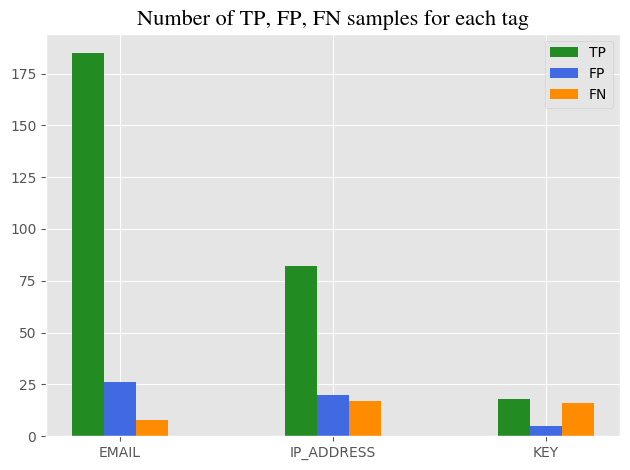

In [59]:
# plot number TP, FP, FN for each tag
# use ggplot style
plt.style.use('ggplot')
tags = ["EMAIL", "IP_ADDRESS", "KEY"]
values = [metrics_dict_2[tag] for tag in tags]
tp = [v["TP"] for v in values]
fp = [v["FP"] for v in values]
fn = [v["FN"] for v in values]
import matplotlib.pyplot as plt
import numpy as np
x = np.arange(len(tags))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots()
# use mat
# use green, dark orange and royal blue and bars shouldn't overlap
rects1 = ax.bar(x - width, tp, width, label='TP', color="#228B22")
rects2 = ax.bar(x, fp, width, label='FP', color="#4169E1")
rects3 = ax.bar(x + width, fn, width, label='FN', color="#FF8C00")

# Add some text for labels, title and custom x-axis tick labels, etc.
# use Mathematica text in title and increase size
ax.set_title('Number of TP, FP, FN samples for each tag', fontname="STIXGeneral", fontsize=16)

ax.set_xticks(x)
ax.set_xticklabels(tags)
ax.legend()

fig.tight_layout()

plt.show()

In [ ]:
# plot precision and recall of each tag from metrics_2
tags = ["EMAIL", "IP_ADDRESS", "KEY"]
values = [metrics_2[tag] for tag in tags]
precision = [v["precision"] for v in values]
recall = [v["recall"] for v in values]
import matplotlib.pyplot as plt
import numpy as np
x = np.arange(len(tags))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(8,5), dpi=140)
c0 = np.array([57, 62, 107])/255*1.5
c1 = np.array([255, 117, 180])/255
# use c0 and c1 as colors
rects1 = ax.bar(x - width/2, precision, width, label='Precision', color=c0)
rects2 = ax.bar(x + width/2, recall, width, label='Recall', color=c1)

# Add some text for labels, title and custom x-axis tick labels, etc.

ax.set_title('Precision and Recall for each entity', fontname="STIXGeneral", fontsize=16)
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1])
ax.set_xticks(x)
ax.set_xticklabels(tags)
ax.set_axisbelow(True)
ax.grid(True, which="major", axis="y")
ax.grid(True, which="minor", axis="y", linestyle='dashed')
ax.legend()

fig.tight_layout()

plt.show()